Import Libraries

In [84]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from wordcloud import WordCloud
from collections import Counter
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import re
import os



Download NLTK Resources

In [85]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/bshanmugam/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Load the Raw Dataset

In [86]:

file_path = "data/amazon_reviews_data.csv"
df = pd.read_csv(file_path)


print(f"Original shape: {df.shape}")

df[['reviews.text', 'reviews.rating']].dropna()
df[df['reviews.text'].str.strip() != '']
df[df['reviews.title'].str.strip() != '']
df['full_review'] = df['reviews.title'].fillna('') + ' - ' + df['reviews.text'].fillna('')
df.rename(columns={'reviews.rating': 'rating','reviews.doRecommend' : 'doRecommend','name':'product_names'}, inplace=True)
print(f"After removing missing: {df.shape}")
df.head(3)

# After first columns exploration here are the columns we will drop as they do not provide useful information for future activities
columntodrop = ["id","dateAdded","dateUpdated","keys","manufacturer","manufacturerNumber","reviews.date","reviews.dateAdded","reviews.dateSeen","reviews.id","reviews.numHelpful","reviews.sourceURLs","reviews.text","reviews.title","reviews.username","reviews.didPurchase"]
df.drop(columns=columntodrop, inplace=True, errors='ignore')
print(f"After removing columns: {df.shape}")

##Remove DUplicates 
print(f"Number of duplicate reviews: {df.duplicated(subset=['full_review']).sum()}")
df = df.drop_duplicates(subset=['full_review'])
print(f"Shape after dropping duplicates: {df.shape}")
df.columns

Original shape: (33332, 25)
After removing missing: (33332, 26)
After removing columns: (33332, 10)
Number of duplicate reviews: 13269
Shape after dropping duplicates: (20063, 10)


/var/folders/7j/c3cwb7d17c1cfkhmkrqtw4q00000gn/T/ipykernel_4373/1208787863.py:2: DtypeWarning: Columns (13,15,24) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


Index(['product_names', 'asins', 'brand', 'categories', 'primaryCategories',
       'imageURLs', 'doRecommend', 'rating', 'sourceURLs', 'full_review'],
      dtype='object')

Visualize Ratings Distribution

/var/folders/7j/c3cwb7d17c1cfkhmkrqtw4q00000gn/T/ipykernel_4373/2570993220.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='rating', data=df, palette='viridis')


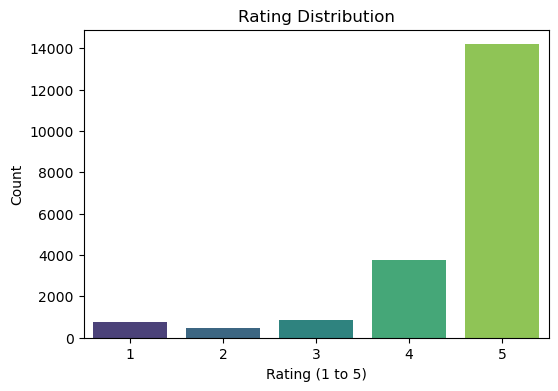

In [87]:
plt.figure(figsize=(6, 4))
sns.countplot(x='rating', data=df, palette='viridis')
plt.title("Rating Distribution")
plt.xlabel("Rating (1 to 5)")
plt.ylabel("Count")
plt.show()


Map Ratings to Sentiment Labels

/var/folders/7j/c3cwb7d17c1cfkhmkrqtw4q00000gn/T/ipykernel_4373/759677541.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=df, palette='coolwarm')


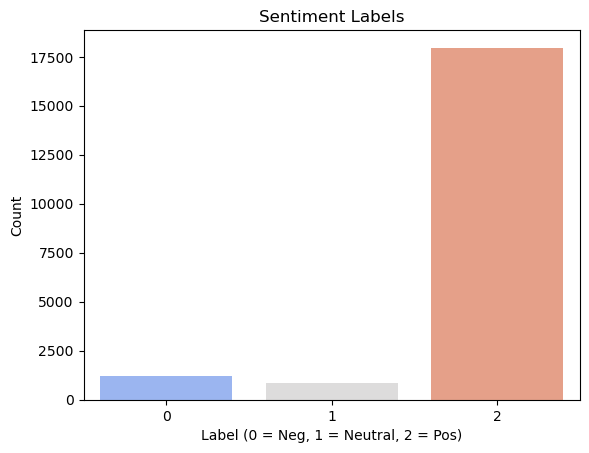

In [88]:
def rating_to_label(r):
    if r in [1, 2]:
        return 0
    elif r == 3:
        return 1
    else:
        return 2

df['label'] = df['rating'].apply(rating_to_label)


sns.countplot(x='label', data=df, palette='coolwarm')
plt.title("Sentiment Labels")
plt.xlabel("Label (0 = Neg, 1 = Neutral, 2 = Pos)")
plt.ylabel("Count")
plt.show()

Clean Text (Simple + Stopwords + Stemming)

In [89]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def simple_clean_text(text):
    text = text.lower()
    text = re.sub(r'<.*?>', '', text)  
    text = re.sub(r'[^a-z\s]', '', text) 
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r"http\S+|@\w+|#\w+", "", text)
    text = re.sub(r"[^\w\s]", "", text)
    text = re.sub(r"\d+", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    tokens = word_tokenize(text)
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(w) for w in tokens if w not in stop_words]
    return ' '.join(tokens)
   


df['clean_text'] = df['full_review'].apply(simple_clean_text)
df[['full_review', 'clean_text']].sample(10)

product_names = df['product_names'].dropna().unique()        
cleaned_names = [simple_clean_text(name) for name in product_names]



Dropping full_reviews column

In [90]:
df.drop(columns='full_review', inplace=True, errors='ignore')
df.columns

Index(['product_names', 'asins', 'brand', 'categories', 'primaryCategories',
       'imageURLs', 'doRecommend', 'rating', 'sourceURLs', 'label',
       'clean_text'],
      dtype='object')

Top Common Words per Sentiment Class

In [91]:
from collections import Counter
import pandas as pd

def get_top_n_words(text_series, n=15):
    # Ensure we are dealing with strings
    all_words = ' '.join(text_series.dropna().astype(str)).split()
    return pd.DataFrame(Counter(all_words).most_common(n), columns=['word', 'count'])

# Loop through each sentiment label and show top words
for label, sentiment in zip([0, 1, 2], ['Negative', 'Neutral', 'Positive']):
    print(f"\n🔹 Top words for {sentiment} reviews:")
    top_words = get_top_n_words(df[df['label'] == label]['clean_text'], n=15)
    print(top_words)



🔹 Top words for Negative reviews:
       word  count
0   battery   1495
1      last    420
2    amazon    380
3       one    377
4      dont    324
5      star    267
6       use    239
7      work    238
8       buy    233
9      long    229
10     good    217
11     time    208
12    brand    202
13      two    183
14    would    182

🔹 Top words for Neutral reviews:
       word  count
0   battery    470
1      good    324
2    tablet    258
3      last    221
4      long    201
5     price    190
6     great    189
7     three    187
8      star    179
9      dont    163
10   amazon    156
11     work    145
12     like    140
13      use    129
14      get    125

🔹 Top words for Positive reviews:
       word  count
0     great  11625
1   battery   8150
2    tablet   5824
3      good   5740
4     price   4849
5      love   4742
6      star   3173
7      work   3162
8       use   3058
9    amazon   2893
10     five   2597
11  product   2431
12      kid   2359
13   kindle   2217
14 

Word Cloud per Sentiment Class

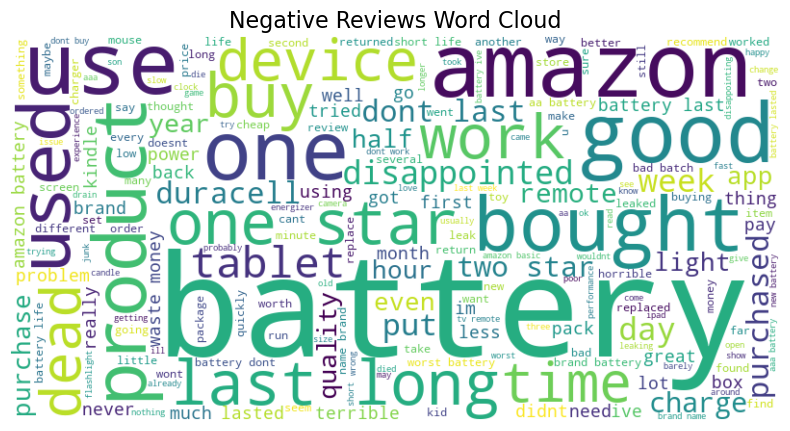

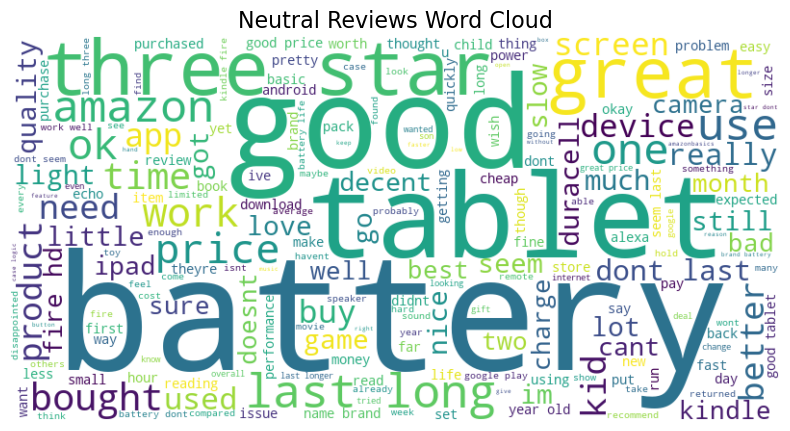

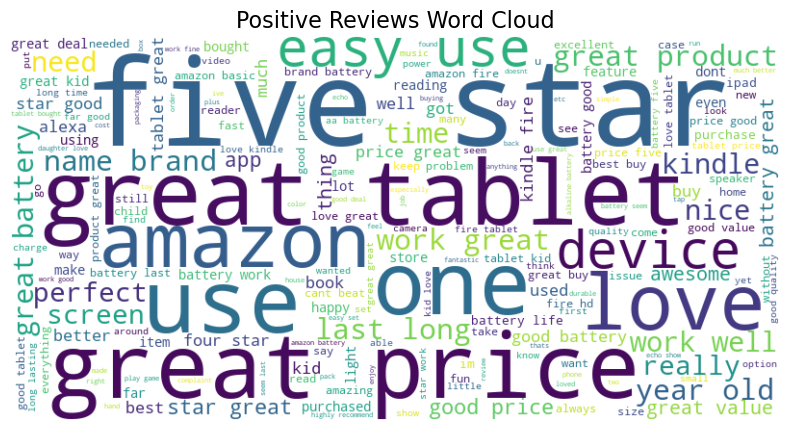

In [92]:
def plot_wordcloud(texts, title):
    text = ' '.join(texts)
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title, fontsize=16)
    plt.show()

for label, sentiment in zip([0, 1, 2], ['Negative', 'Neutral', 'Positive']):
    plot_wordcloud(df[df['label'] == label]['clean_text'], f"{sentiment} Reviews Word Cloud")


Save the Final Cleaned Dataset

In [93]:
os.makedirs("data", exist_ok=True)
df.to_csv("data/cleaned_amazon_reviews_final.csv", index=False)
print("✅ Saved: data/cleaned_amazon_reviews_final.csv")

✅ Saved: data/cleaned_amazon_reviews_final.csv
